Methods 4 - Linear Regression
-----------------------------
12.2.2020  
Mathematics and Methods in Machine Learning and Neural Networks  
Helsinki Metropolia University of Applied Sciences

In this exercise, we build a __linear multiple regression__ model to predict either the quality or alcohol content of red wine. The data set contains a selection of chemical properties, and a subjective quality score from 0 to 10.

We did some quick testing to predict the subjective wine quality score based on the chemical properties using linear regression. The error metrics were bad, so we opted to try and __predict alcohol content based on other chemical properties__, instead.

Data source: http://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
url = r'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
df = pd.read_csv(url, 
                 sep = ';', 
                 index_col = None)
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Let's first look at simple correlation to alcohol content:

In [3]:
# correlation of the explanatory variables to alcohol content
correlation = np.abs(df.corr()['alcohol']).sort_values(ascending=False)
correlation

alcohol                 1.000000
density                 0.496180
quality                 0.476166
chlorides               0.221141
total sulfur dioxide    0.205654
pH                      0.205633
volatile acidity        0.202288
citric acid             0.109903
sulphates               0.093595
free sulfur dioxide     0.069408
fixed acidity           0.061668
residual sugar          0.042075
Name: alcohol, dtype: float64

Preprocessing
-------------

In [24]:
# standardize
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# separate independent variables from the response variable
X = df.drop(['alcohol'], axis=1)
y = df.filter(['alcohol'])
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03
mean,-1.527511e-17,-8.956771e-17,4.549207e-16,-8.241618e-17,8.658212e-17,1.610136e-16,1.094427e-16,5.182429e-16,-2.129490e-16,9.212152e-17,9.226169e-16,-8.179476e-16
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00
min,-2.137045e+00,-2.278280e+00,-1.391472e+00,-1.162696e+00,-1.603945e+00,-1.422500e+00,-1.230584e+00,-3.538731e+00,-3.700401e+00,-1.936507e+00,-1.898919e+00,-3.265165e+00
25%,-7.007187e-01,-7.699311e-01,-9.293181e-01,-4.532184e-01,-3.712290e-01,-8.487156e-01,-7.440403e-01,-6.077557e-01,-6.551405e-01,-6.382196e-01,-8.663789e-01,-7.878226e-01
50%,-2.410944e-01,-4.368911e-02,-5.636026e-02,-2.403750e-01,-1.799455e-01,-1.793002e-01,-2.574968e-01,1.760083e-03,-7.212705e-03,-2.251281e-01,-2.093081e-01,4.508484e-01
75%,5.057952e-01,6.266881e-01,7.652471e-01,4.341614e-02,5.384542e-02,4.901152e-01,4.723184e-01,5.768249e-01,5.759223e-01,4.240158e-01,6.354971e-01,4.508484e-01
max,4.355149e+00,5.877976e+00,3.743574e+00,9.195681e+00,1.112703e+01,5.367284e+00,7.375154e+00,3.680055e+00,4.528282e+00,7.918677e+00,4.202453e+00,2.928190e+00


In [5]:
# split validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Feature Selection
-----------------

Let's build a linear model to infer feature importances (coefficients of the standardized variables).

In [6]:
model = LinearRegression()
model.fit(X_train, y_train)
c = pd.DataFrame(model.coef_, columns=X.columns)
print("Intercept:", model.intercept_)
print("Coefficients:")
coefficients = np.abs(c.T[0]).sort_values(ascending=False)
coefficients

Intercept: [-0.01946239]
Coefficients:


density                 1.012831
fixed acidity           0.801315
pH                      0.540272
residual sugar          0.335543
quality                 0.179554
sulphates               0.160258
citric acid             0.139444
volatile acidity        0.106840
free sulfur dioxide     0.055365
chlorides               0.032029
total sulfur dioxide    0.012371
Name: 0, dtype: float64

Here we also generate another set of variable importances using weights from a gradient boosting model (XGBoost).

In [7]:
xgb = XGBRegressor()
fit = xgb.fit(X_train, y_train)
xgboost = pd.DataFrame(fit.feature_importances_, index=X.columns)[0].sort_values(ascending=False)

[12:51:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Combine importance metrics in a pandas data frame:

In [8]:
importances = pd.DataFrame()
importances['regression coefficient'] = coefficients
importances['correlation coefficient'] = correlation
importances['XGBoost weight'] = xgboost
importances = importances.dropna()
importances

,regression coefficient,correlation coefficient,XGBoost weight
density,1.012831,0.496180,0.223949
fixed acidity,0.801315,0.061668,0.050529
pH,0.540272,0.205633,0.045970
residual sugar,0.335543,0.042075,0.070772
quality,0.179554,0.476166,0.301292
sulphates,0.160258,0.093595,0.040741
citric acid,0.139444,0.109903,0.098072
volatile acidity,0.106840,0.202288,0.019596
free sulfur dioxide,0.055365,0.069408,0.047092
chlorides,0.032029,0.221141,0.035298


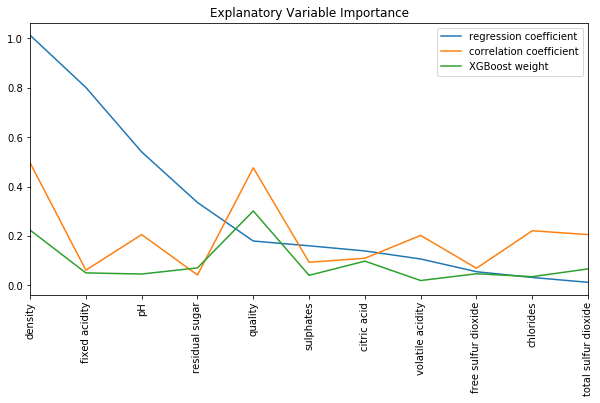

In [9]:
importances.plot(figsize=(10,5), xticks=np.arange(0, 11), rot=90)
plt.title("Explanatory Variable Importance")
plt.show()

The five most useful variables, based on regression coefficients are:

1. density
2. fixed acidity
3. pH
4. residual sugar
5. (quality)
6. sulphates

Linearity
---------

The first assumption of a linear model is that the relationship should be linear. Let's plot our chosen five "most useful" variables against alcohol content:

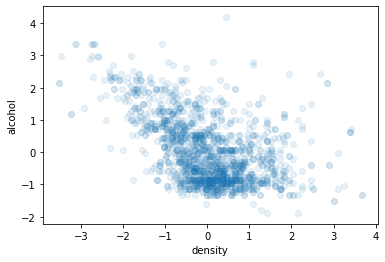

In [10]:
plt.scatter(df['density'], df['alcohol'], alpha=0.1)
plt.xlabel('density')
plt.ylabel('alcohol')
plt.show()

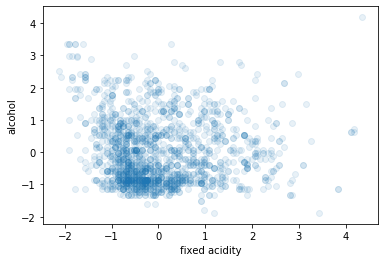

In [11]:
plt.scatter(df['fixed acidity'], df['alcohol'], alpha=0.1)
plt.xlabel('fixed acidity')
plt.ylabel('alcohol')
plt.show()

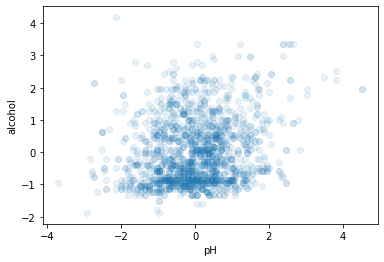

In [12]:
plt.scatter(df['pH'], df['alcohol'], alpha=0.1)
plt.xlabel('pH')
plt.ylabel('alcohol')
plt.show()

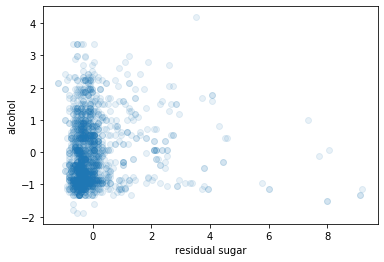

In [13]:
plt.scatter(df['residual sugar'], df['alcohol'], alpha=0.1)
plt.xlabel('residual sugar')
plt.ylabel('alcohol')
plt.show()

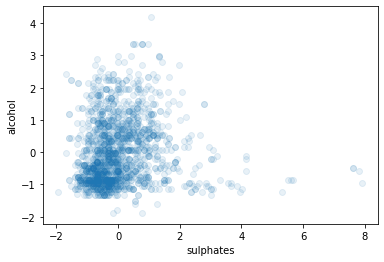

In [14]:
plt.scatter(df['sulphates'], df['alcohol'], alpha=0.1)
plt.xlabel('sulphates')
plt.ylabel('alcohol')
plt.show()

Multicollinearity
-----------------

Another assumption of linear regression is that the explanatory variables be independent of each other.

Let's see if any of the explanatory variables are correlated to each other:

In [15]:
columns_alc = ['density', 'fixed acidity', 'pH', 'residual sugar', 'sulphates']
columns_qual = ['alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide', 'chlorides']
X_train = X_train.filter(columns_alc)
X_test = X_test.filter(columns_alc)
X_train.corr()

,density,fixed acidity,pH,residual sugar,sulphates
density,1.000000,0.664831,-0.340158,0.397699,0.165810
fixed acidity,0.664831,1.000000,-0.672233,0.131829,0.191676
pH,-0.340158,-0.672233,1.000000,-0.108281,-0.224370
residual sugar,0.397699,0.131829,-0.108281,1.000000,0.015637
sulphates,0.165810,0.191676,-0.224370,0.015637,1.000000


It seems that `density` and `fixed acidity` have a pretty strong correlation.

However: "_Multicollinearity affects the coefficients and p-values, but it does not influence the predictions, precision of the predictions, and the goodness-of-fit statistics. If your primary goal is to make predictions, and you don’t need to understand the role of each independent variable, you don’t need to reduce severe multicollinearity._" [Jim Frost - Multicollinearity in Regression Analysis: Problems, Detection, and Solutions](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/)

As our primary goal in this exercise is to make predictions, we skip multicollinearity tests (VIF etc.) and simply ignore the above correlation.

In [16]:
test_model = LinearRegression()
test_model.fit(X_train, y_train)
c = pd.DataFrame(test_model.coef_, columns=X_train.columns)
print("Intercept:", test_model.intercept_)
print("Coefficients:")
coefficients = np.abs(c.T[0]).sort_values(ascending=False)
coefficients

Intercept: [-0.01801294]
Coefficients:


density           1.129707
fixed acidity     0.997852
pH                0.587810
residual sugar    0.364036
sulphates         0.199904
Name: 0, dtype: float64

The __regression equation__ is  
$$\hat{Y_i} = \beta_0 + \beta_1X_{1i} + \beta_2X_{2i} + \beta_3X_{3i} + \beta_4X_{4i} + \beta_5X_{5i} + \epsilon_i$$
$$= -0.018 + 1.129X_{1i} + 0.998X_{2i} + 0.588X_{3i} + 0.364X_{4i} + 0.200X_{5i} + \epsilon_i$$

Let's also try fitting the model using the `statsmodels` library:

In [17]:
ols = sm.OLS(y_train, X_train)
res = ols.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                alcohol   R-squared (uncentered):                   0.636
Model:                            OLS   Adj. R-squared (uncentered):              0.634
Method:                 Least Squares   F-statistic:                              372.3
Date:                Fri, 14 Feb 2020   Prob (F-statistic):                   6.66e-231
Time:                        12:52:05   Log-Likelihood:                         -981.36
No. Observations:                1071   AIC:                                      1973.
Df Residuals:                    1066   BIC:                                      1998.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

All kinds of statistics are printed.

In [18]:
y_pred = test_model.predict(np.asarray(X_test))

# compute error statistics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred) 
print("MSE = ", mse)
print("MAE = ", mae)
print("R2 = ", r2)

MSE =  0.30003761333823353
MAE =  0.4207955795332466
R2 =  0.6968676746584619


According to these metrics, our model's predictive power is rather unimpressive.

Let's have a look at the residuals, if we can find any problems there.

In [19]:
# merge observed and predicted values and compute residuals
df2 = pd.DataFrame()
df2['observed'] = y_test['alcohol']
df2['predicted'] = y_pred.flatten()
df2['residual'] = y_test['alcohol'] - y_pred.flatten()
df2

,observed,predicted,residual
1109,0.353895,0.003160,0.350736
1032,-0.772512,-0.779469,0.006957
1002,1.198701,1.273021,-0.074320
487,-0.397043,-0.819398,0.422355
979,-0.021574,1.097667,-1.119240
...,...,...,...
1283,-0.209308,-0.341452,0.132144
195,-0.960246,-0.859140,-0.101106
977,-1.241848,-1.512743,0.270895
708,1.104833,0.174357,0.930477


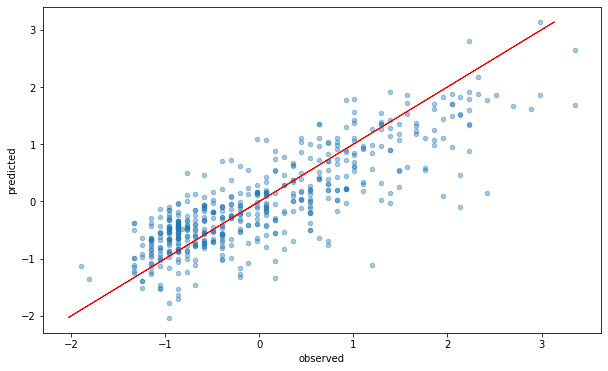

In [20]:
# plot observed vs predicted values
df2.plot.scatter(x='observed', y='predicted', figsize=(10,6), alpha=0.4)
plt.plot(y_pred, y_pred, color='red', linewidth=1)
plt.show()

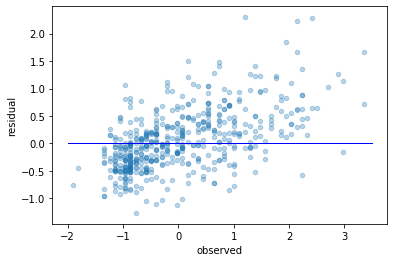

In [21]:
# plot residuals
df2.plot.scatter(x='observed', y='residual', alpha=0.3)
plt.plot([-2,3.5], [0,0], color='blue', linewidth=1)
plt.show()

Something is definitely wrong with this model. All the data on the left is below the fitted line, and all the data on the right is above it. This needs further investigation.

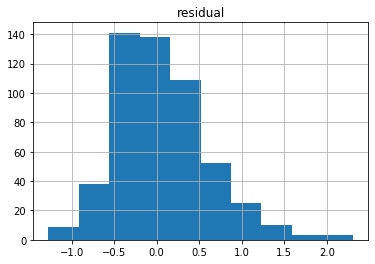

In [22]:
# histogram of residuals to see if they are normally distributed
df2.hist('residual')
plt.show()